In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from scipy import interpolate
from scipy.optimize import curve_fit

## NOTES ##

Scale on the characteristic curve seems off, and how should it change when temp is changed 

Should the RH data be from 0 to 1 or 1 to 100, and how is that translated across functions? 

Also np.exp function freaks out when I enter numbers that are too large 

Does 1/RH work for the polanyi potential calculation 

Is the n function too complicated that it's hard to optimize the rho function?

Need molar mass of MOF to plug into 

## data sources
* MOF-801 [here](https://www.nature.com/articles/s41467-018-03162-7) [TODO: correct.]

In [94]:
R = 8.314 # J/(mol-K)

In [100]:
def read_ads_data(mof, temperature):
    ads_data = pd.read_csv('data/{}_{}C_samplecurve.csv'.format(mof, temperature))
    
    ads_data['P/P_0'] = ads_data['RH[%]'] / 100
    
    # polanyi adsorption potential
    ads_data["A"] = -R * temperature * np.log(ads_data['P/P_0'])
    
    ads_data = ads_data.drop(columns=['RH[%]'])
    return ads_data

In [101]:
ads_data = read_ads_data("mof_801", 25)
ads_data.head()

,Water Uptake [kg kg-1],P/P_0,A
0,0.054,0.01,957.184623
1,0.060,0.02,813.113982
2,0.068,0.03,728.838059
3,0.075,0.04,669.043340
4,0.085,0.05,622.662953


In [102]:
def viz(ads_data):
    fig = plt.figure()           
    plt.scatter(ads_data['P/P_0'], ads_data['Water Uptake [kg kg-1]'])
    plt.title('MOF-801 adsorption isotherm at 25$^\circ$C')
    plt.xlabel('relative humidity, $P/P_0$')
    plt.ylabel('water uptake [kg/kg]')
    plt.ylim(ymin=0)
    plt.xlim(0, 1)
    return fig

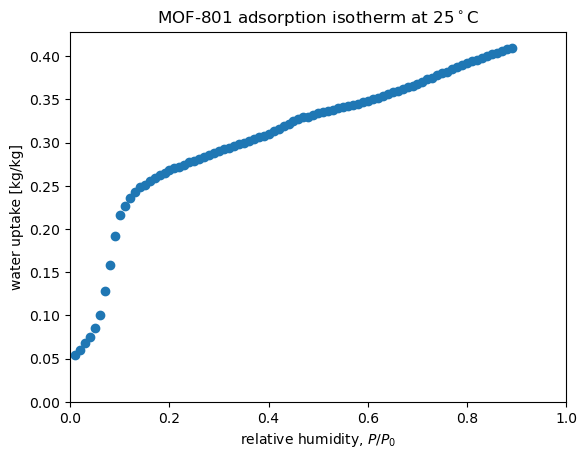

In [103]:
viz(ads_data)
plt.show()

In [104]:
n_of_P = interpolate.CubicSpline(ads_data['P/P_0'], ads_data['Water Uptake [kg kg-1]'])

In [105]:
n_max = n_of_P(1.0).item()
n_max

0.4320165807198769

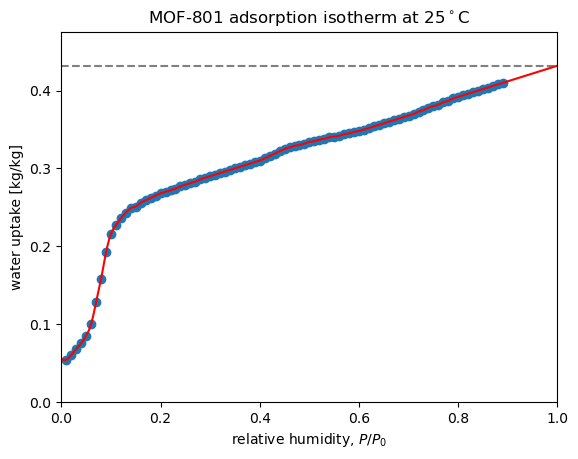

In [106]:
p = np.linspace(0, 1, 250)

fig = viz(ads_data)
fig.axes[0].axhline(n_max, color="gray", linestyle="--")
fig.axes[0].plot(p, n_of_P(p), c='red')
fig.axes[0].set_ylim(0, n_max * 1.1)

plt.show()

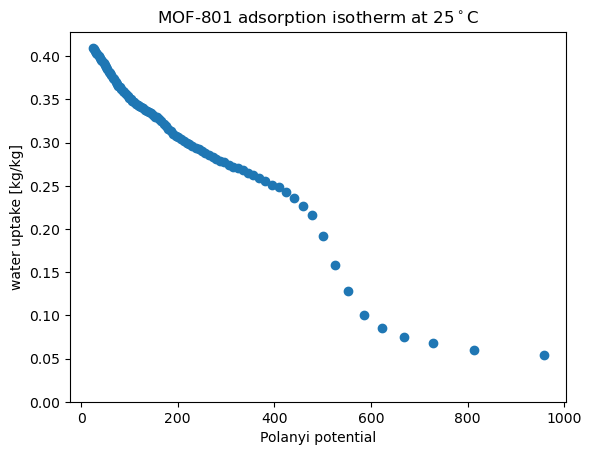

In [112]:
fig = plt.figure()           
plt.scatter(ads_data['A'], ads_data['Water Uptake [kg kg-1]'])
plt.title('MOF-801 adsorption isotherm at 25$^\circ$C')
plt.xlabel('Polanyi potential')
plt.ylabel('water uptake [kg/kg]')
plt.ylim(ymin=0)
# plt.xlim(0, 1)
plt.show()

In [18]:
#Source for weather data 
#https://weathersight.io/timeseries
#For Phoenix from 2020-2021
df_weather = pd.read_csv('data/Phoenix_weather_edited_final.csv')


In [113]:
#Characteristic Curve at temp T
def characteristic_curve(T):

    #Get curve and max adsorption data 
    eta_max, n = n_curve(df_MOF_801)
    
    #Create an array to store A values, then calculate A for every value of RH 
    A_values = []
    columns = ['A values']

    #Run through every range of RH 
    for i in range(101):
        A = polanyi_potential(T,(i+1))
        A_values.append(A)

    df_A = pd.DataFrame(data = A_values, columns = columns)

    return df_A

#Plot n(A) to find characteristic curve 
df_A = characteristic_curve(25)
x = df_A['A values']
plt.plot(x,n(x))
plt.title('Polanyi Characteristic Curve')
plt.xlabel('Polanyi Potential [J/mol]')
plt.ylabel('Water Uptake [kg kg-1]')
plt.show()

NameError: name 'df_MOF' is not defined

In [53]:
#Fit water uptake equation to characteristic curve for all values of p 
#Calculates the value of Eta for a given E and b for all values of 
def Eta_calculation(E,b):

    #Define temp of curve to look at 
    T = 25

    #Get curve and max adsorption data 
    eta_max, n = n_curve(df_MOF_801)

    #Calculate eta for every value of A (which is a function of RH)
    A_values = []
    Eta_values = []
    Curve_values = []

    for i in range(101):
        A = polanyi_potential(T,(i+1))
        A_values.append(A)

        Eta = eta_max*np.exp((A_values[i+1]/E)**b)
        Eta_values.append(Eta)

        Curve_value = n(A_values[i+1]).item()
        Curve_values.append(Curve_value)

    #This Dataframe is just to look at the values of Eta vs. n(A)
    columns = ['A values']
    df_Final = pd.DataFrame(data = A_values, columns = columns)
    df_Final.insert(1,'Eta',Eta_values,True)
    df_Final.insert(2,'n(A)',Curve_values,True)

    return Eta_values 

In [289]:
#Optimize eta(RH) to fit n(A)
#If eta(RH) fits n(A), won't it be different than the curve n(RH)?

#Equation given:
#l(b,E) = sum(i) [n_i - eta_max*exp([A_i/E]**b)]**2
#Goal: find b, E = argmin l(b,E)
#Don't really understand how optimization works 

In [57]:
#Need a function that pulls the weekly data out of the dataframe 
def weekly_data(week): 
    
    Week_x = df_weather['Week'] == week 
    T_max = df_weather[Week_x]['T_max_mean[C]'].values[0]
    T_min = df_weather[Week_x]['T_min_mean[C]'].values[0]
    Max_dewp = df_weather[Week_x]['Max_dewp[C]'].values[0]
    Min_dewp = df_weather[Week_x]['Min_dewp[C]'].values[0]
    
    return T_max, T_min, Max_dewp, Min_dewp

In [60]:
#Find the saturated vapor pressure from temp and dewp 
#source for formula 
#https://www.weather.gov/media/epz/wxcalc/vaporPressure.pdf
def pressure_calculations(T,T_dew):
    
    P_0 = 6.11 * 10**((7.5*T)/(237.3+T))
    P = 6.11 * 10**((7.5*T_dew)/(237.3+T_dew))
    RH = P/P_0
    
    return P_0, P, RH 

In [ ]:
#Calculate how much water a MOF would make per day at given weekly conditions 
def calculate_water(week,g_MOF)
    
    #Get weather data from week 
    T_max, T_min, Max_dewp, Min_dewp = weekly_data(week)
    
    #Calculate pressure data
    P_0_high, P_high, RH_high = pressure_calculations(T_max,Max_dewp)
    P_0_low, P_low, RH_low = pressure_calculations(T_min,Min_dewp)
    
    #Generate new curves with polanyi function at high and low temps 
    #Water_rate = polanyi_high(RH_high) and polanyi_low(RH_low) to find how much water is in each at equalibrium 
    #Water_total = Water_rate * g_MOF
    
    return Water_total